# Stochastic Trace Estimation

This Jupyter 1-pager gives a brief introduction to Monte Carlo techniques for trace estimation. It also summarizes the contributions of the following papers:

1. *A multilevel approach to stochastic trace estimation* (E.H. and Devon Troester, 2022) [LAA](https://www.sciencedirect.com/science/article/abs/pii/S0024379521004390) [arXiv](https://arxiv.org/pdf/2103.10516.pdf)
2. *Krylov-aware stochastic trace estimation* (Tyler Chen and E.H., 2023) [SIMAX](https://epubs.siam.org/doi/abs/10.1137/22M1494257) [arXiv](https://arxiv.org/pdf/2205.01736.pdf)
3. *Monte Carlo methods for estimating the diagonal of a real symmetric matrix* (E.H., Ilse C.F. Ipsen, and Arvind K. Saibaba, 2023) [SIMAX](https://epubs.siam.org/doi/abs/10.1137/22M1476277) [arXiv](https://arxiv.org/pdf/2202.02887.pdf)
4. *Faster Stochastic Trace Estimation with a Chebyshev Product Identity* (E.H., 2021) [Applied Math. Letters](https://www.sciencedirect.com/science/article/abs/pii/S0893965921001269)

## Table of Contents
1. [Introduction](#intro)
    1. [Motivating Examples](#intro:examples)
    2. [Monte Carlo Estimators](#intro:estimators)
       1. [Hutchinson's Estimator](#intro:hutch)
    3. [Matrix Function Evaluation](#matfun)
       1. [Example for Chebyshev Series](#matfun:cheby)
      
## TL;DR

We want to compute something related to a matrix function $f(A)$ that requires us to know the eigenvalues of $A$. If $A$ is too large, we go for an approximation instead. The three basic prongs of this approach are

1. Use Monte Carlo random sampling
2. Approximate the function $f(x)$ with
    1. A carefully chosen polynomial (ideally a [Chebyshev series](https://en.wikipedia.org/wiki/Chebyshev_polynomials)); or
    2. The [Lanczos method](https://en.wikipedia.org/wiki/Lanczos_algorithm)
3. Find ways to reduce the variance of the estimator.
    1. The **Hutch++** approach is find a low-rank approximation to $f(A)$ and split the matrix as $f(A) = f(A)_{\text{lowrank}} + f(A)_{\text{remainder}}$. We can compute our desired quantity exactly for the first part, and sampling the second part is expected to have lower variance.
  
The principal contributions of the papers mentioned above are then as follows:

1. We try to reduce the variance of the estimator by splitting the polynomial $f(x)\approx p(x)$ into multiple terms $p(x) = p_1(x) + p_2(x) + \ldots + p_k(x)$. The "multilevel" approach is to sample the low-degree polynomials many times and the high-degree polynomials (which hopefully have small variance) a few times. A properly chosen split and sampling ratio has the potential to reduce the computation by a modest factor (up to 2-3x depending on the problem).
2. We augment the **Hutch++** method by showing how to more efficiently compute a low-rank approximation to $f(A)$.
3. We derive error bounds on a certain class of estimators.
4. When $f(x)$ is approximated by a Chebyshev polynomial, I demonstrate a trick for computing a degree-$n$ polynomial using only $\lceil n/2\rceil$ matrix products. Sadly, it turns out that I was far from the first to discover this trick.

## Introduction <a name="intro"></a>

The **trace** of a matrix is the sum of its diagonal elements, which is also equal to the sum of its eigenvalues.

$$\text{Tr}(A) = \sum_i A_{ii} = \sum_i \lambda_i(A).$$

Sometimes we wish to know the trace of some function of our matrix $f(A)$. We could compute the answer easily if we knew all the eigenvalues of $A$, but if the matrix is very large then this approach is impractical.

### Motivating Examples <a name="intro:examples"></a>

* Let $A$ be the adjacency matrix for a graph. The number of triangles in the graph is equal to $\tfrac{1}{6}\text{Tr}(A^3)$. If $A$ is very large (say, representing a social network with 100 million people) then we would have difficulty computing $A^3$ explicitly.
* The Estrada index of a graph (one measure of connectedness) is $\text{Tr}(e^A)$. 
* The log determinant of a matrix can be represented as $\log \det(A) = \log \prod_i \lambda_i = \sum_i \log(\lambda_i) = \text{Tr}(\log(A))$.
* The nuclear norm of a matrix is equal to $\text{Tr}\left((A^TA)^{1/2}\right)$.


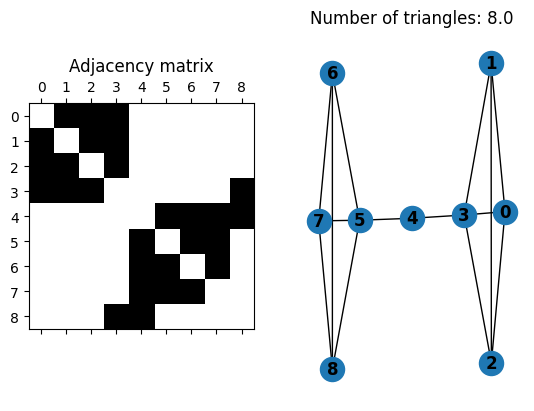

In [39]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

G = nx.barbell_graph(4,1)
A = nx.to_numpy_array(G)
ax1 = plt.subplot(121)
plt.spy(A)
plt.title("Adjacency matrix")
ax2 = plt.subplot(122)
nx.draw(G, with_labels=True, font_weight='bold')
num_triangles = (1/6) * numpy.trace(np.linalg.matrix_power(A,3))
plt.title(f"Number of triangles: {num_triangles}")
plt.show()

### Monte Carlo estimators <a name="intro:estimators"></a>

Random sampling to the rescue! Here's an idea for our triangle counting problem: we pick a *random vertex* in the graph, then see how many triangles include that vertex. We can generalize this idea, too. First, a bit of notation:

* The matrix $A$ is $d\times d$.
* The vector $e_i$ is the $i$th standard basis vector in $\mathbb{R}^d$: $e_i = [\underbrace{0,\ldots,0}_{i-1},1,0,\ldots,0]^T$.
* The random vector $z$ is equal to $\sqrt{d}e_i$ with uniform probability $\tfrac{1}{d}$ for $1\leq i \leq d$.
* We will take $N$ samples, indexed as $z_j$ for $1\leq j \leq N$.

we could say that if $A$ is $d\times d$, then $$\text{Tr}(f(A)) = \sum_{i=1}^d f(A)_{ii} = \sum_{i=1}^de_i^Tf(A)e_i \approx \frac{1}{N}\sum_{j=1}^Nz_j^Tf(A)z_j.$$

**Advantage**: Now instead of computing $f(A)$ or the eigenvalues of $A$ (cost $\mathcal{O}(d^3)$), we can get away with computing only matrix-vector products (cost $\mathcal{O}(Nd^2)$). In the case of our triangle-counting example, the best order of operations is $$z^TA^3z = (Az)^T(A(Az)),$$ which requires only 2 matrix-vector products if we save the value of $Az$.

**Limitation**: Monte Carlo estimators in general give an approximation with error $\mathcal{O}(1/\sqrt{N})$, so don't expect an exact answer. More critically, this choice of $z$ has a **needle/haystack problem**: if $A$ is large but most of its vertices have no triangles, we will need to take many samples to have a good chance of finding the few that do.

#### Hutchinson's estimator <a name="intro:hutch"></a>

Here are two better choices for $z$:

1. The entries of $z$ are independent and normally distributed with mean zero (Gaussian estimator).
2. The entries of $z$ are independent and equal to $\pm 1$ with equal probability $1/2$ (Hutchinson's estimator).

In general these estimators are known as *quadratic trace estimators*. Despite the name their use did not originate with Hutchinson; my colleague Tyler Chen has done good work in summarizing the origins (e.g. [here](https://arxiv.org/pdf/2204.01941.pdf)). The general idea is that if $\mathbb{E}[zz^T] = I_d$ then by properties of expectation and the trace operator, $$\mathbb{E}[z^Tf(A)z] = \mathbb{E}[\text{Tr}(z^Tf(A)z)] = \mathbb{E}[\text{Tr}(f(A)zz^T)] = \text{Tr}\left(\mathbb{E}[f(A)zz^T]\right) = \text{Tr}\left(f(A)\mathbb{E}[zz^T]\right) = \text{Tr}\left(f(A)I_d\right) = \text{Tr}(f(A)).$$

One nice property of Hutchinson's estimator is that it returns the exact answer with a single sample if $f(A)$ is diagonal.

In [108]:
from enum import Enum

class Estimator(Enum):
    COORD = 1
    GAUSS = 2
    HUTCH = 3

def count_triangles(A, method=Estimator.COORD, N = 100):
    estimates = np.zeros((N,))
    d = A.shape[0]
    for i in range(N):
        if method == Estimator.COORD:
            z = np.zeros((d,))
            z[np.random.randint(d)] = np.sqrt(d)
        elif method == Estimator.GAUSS:
            z = np.random.randn(d)
        elif method == Estimator.HUTCH:
            z = 2*np.random.randint(2, size=d) - 1

        Az = A@z
        estimates[i] = (1/6) * (Az.T)@(A@(Az))
        
    return estimates

The following example uses the three types of estimators to count the number of triangles in our graph. I'll caution that this particular choice of graph allows the coordinate estimator to perform better than it would in a worst-case scenario.

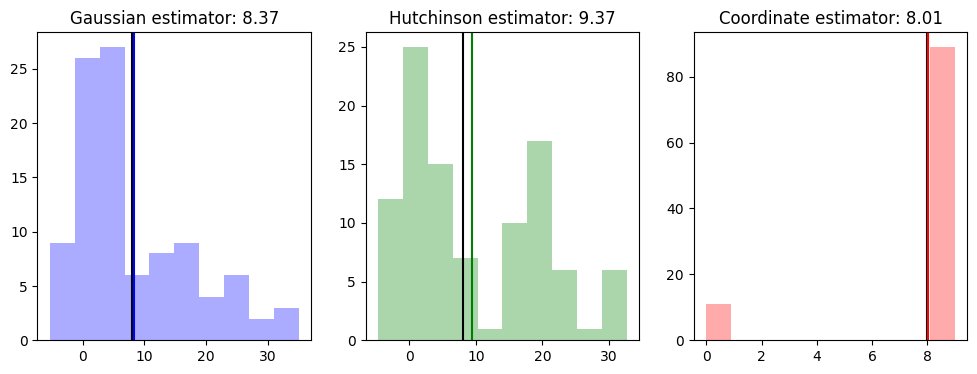

In [164]:
estimators = [Estimator.GAUSS, Estimator.HUTCH, Estimator.COORD]
colors = ['b', 'g', 'r']
names = ["Gaussian", "Hutchinson", "Coordinate"]

fig, axlist = plt.subplots(1,3, figsize=(12,4))
axlist = axlist.ravel()

for i,ax in enumerate(axlist):
    ax.axvline(x=num_triangles, color='k')
    e = count_triangles(A, method=estimators[i], N = 100)
    ax.hist(e, alpha=0.33, color=colors[i])
    ax.axvline(x=np.mean(e), color=colors[i])
    ax.set_title(names[i] + f" estimator: {np.mean(e):.2f}")

plt.show()

## Matrix function evaluation <a name="matfun"></a>

The above strategy works pretty well as long as we're dealing with polynomials such as $f(A) = \tfrac{1}{6}A^3$. What about other functions such as $f(x) = \exp(x), \log(x), \sqrt{x}$? 

The two most common methods are

1. Approximating $f(x)$ by a [Chebyshev series](https://en.wikipedia.org/wiki/Chebyshev_polynomials)
   1. Upside: lower memory overhead costs compared to Lanczos
   2. Downside: requires an approximation to the largest and smallest eigenvalues of $A$
2. Using the [Lanczos method](https://en.wikipedia.org/wiki/Lanczos_algorithm)

Either way, we must choose a degree $n$ (or number of iterations) that gives a sufficiently good approximation to $f$.

### Example for Chebyshev series <a name="matfun:cheby"></a>

The Chebyshev polynomials follow the recursive relation $$T_0(x) = 1;\quad T_1(x) = x;\quad T_{n+1}(x) = 2xT_n(x) - T_{n-1}(x).$$ When we approximate a function by a low-degree polynomial, the Chebyshev series tends to give better approximations overall than other approximations such as the Taylor series. The authoritative MATLAB package for this topic is [Chebfun](https://www.chebfun.org/about/).

The functions below give Chebyshev approximations to a function on the interval $[-1,1]$. In general we want to get a good approximation on the interval $[\lambda_{\min}, \lambda_{\max}]$, which requires some shifting and scaling. The coefficients returned by the first function give us the series approximation $$f(x) \approx \sum_{i=0}^k a_iT_i(x).$$ The second function evaluates the series on a given set of input values.

With matrices, we get the recursive relation $$T_0(A)z = z;\quad T_1(A)z = Az;\quad T_{n+1}(A)z = 2AT_n(A)z - T_{n-1}(A)z,$$
which, with $z_n = T_n(A)z$, can be rewritten as $$z_0 = z;\quad z_1 = Az;\quad z_{n+1} = 2Az_n - z_{n-1}.$$

In [195]:
def cheby_approx(f, degree=3):
    dt = 0.01
    ts = np.arange(0, np.pi, dt)
    coeffs = np.zeros((degree+1,))
    for k in range(degree+1):
        coeffs[k] = (2/np.pi) * np.trapz(f(np.cos(ts))*np.cos(k*ts),dx=dt)
    coeffs[0] = coeffs[0]/2
    return coeffs

def cheby_val(coeffs, xs):
    Tx_n = np.ones_like(xs)
    ys = coeffs[0] * Tx_n

    if len(coeffs) > 1:
        Tx_nplus1 = xs
        ys += coeffs[1] * Tx_nplus1

    for c in coeffs[2:]:
        Tx_nplus1, Tx_n = 2*xs*Tx_nplus1 - Tx_n, Tx_nplus1
        ys += c * Tx_nplus1

    return ys

def chebyval_mat(coeffs, A, z):
    z_n = z
    y = coeffs[0] * z

    if len(coeffs) > 1:
        z_nplus1 = A@z
        y += coeffs[1] * z_nplus1

    for c in coeffs[2:]:
        z_nplus1, z_n = 2*(A@z_nplus1) - z_n, z_nplus1
        y += c * z_nplus1

    return y
    

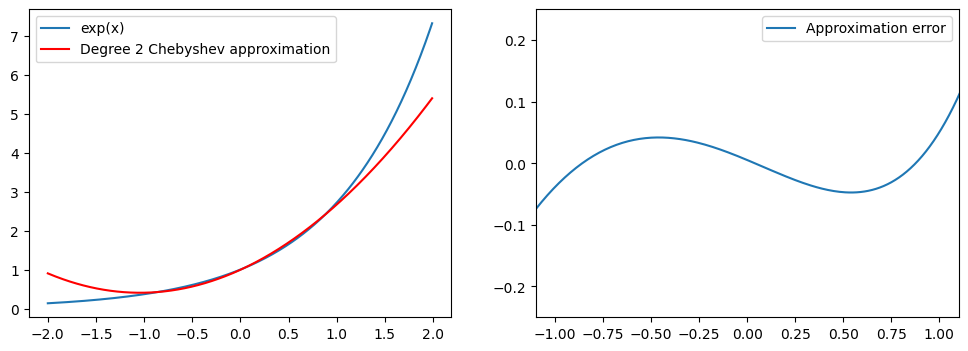

In [213]:
xs = np.arange(-2,2,0.01)
coeffs = cheby_approx(np.exp, 2)
ys = cheby_val(coeffs,xs)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(xs, np.exp(xs))
plt.plot(xs, ys, color='r')
plt.legend(["exp(x)", "Degree 2 Chebyshev approximation"])

plt.subplot(122)
plt.plot(xs, np.exp(xs) - ys)
plt.legend(["Approximation error"])
plt.xlim([-1.1,1.1])
plt.ylim([-0.25,0.25])
plt.show()

The matrix example below works well for $f(A) = \exp(A)$ because the eigenvalues of $A$ are all in the interval $[-1,1]$, which is the interval our Chebyshev series coefficients were optimized for.

In [207]:
from scipy.linalg import expm

Q,_ = numpy.linalg.qr(numpy.random.randn(4,4))
A = Q@numpy.diag([-.8, -.2, 0.5, 1])@Q.T
z = np.random.randn(4)

y_exact = expm(A)@z
y_approx = chebyval_mat(coeffs, A, z)
print("Relative error: ", np.linalg.norm(y_exact-y_approx)/np.linalg.norm(y_exact))

Relative error:  0.025813021216808445


# Multilevel Polynomials for Variance Reduction